# Financial Data Extractor V5.2
### add exception handling
### add Test case
### add feature to extract name from web and name file or keep user defined name (cond in constructor)

In [1]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
#import html5lib 
import lxml
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from cachetools import cached, TTLCache

In [3]:
class Financial_Extractor:
    report_cache = TTLCache(maxsize=100, ttl=3600) 
    L1_cache = TTLCache(maxsize=100, ttl=3600) 
    

    def __init__(self, user_input, years = 10, docs = ["balance sheet","profit loss","cash flow"], filepath = "") -> None:
        self.user_input = user_input.replace(" ","")
        self.years = years
        self.docs = docs
        if(self.user_input.isnumeric() and len(self.user_input) == 6):
            self.company = self.__comp_name(self.user_input)
        else:
            self.company = self.user_input
        self.filepath = filepath

    def plotter(self,attr,doc="balance sheet"):
        df = self.search_gen(self.company+" moneycontrol consolidated "+ doc, self.years)
        row_num = df[df[df.columns[0]] == attr].index
        #column_names = list(df.columns)
        col_names = df.loc[0, :].values.flatten().tolist()
        X = col_names[1:]
        X.reverse()
        print(X)
        row_list = df.loc[row_num, :].values.flatten().tolist()
        Y = row_list[1:]
        Y.reverse()
        Y = [float(i) for i in Y]
        print(Y)
        plt.plot(X,Y,"-o")
        plt.show()


    @cached(cache=L1_cache)
    def __urlfinder(self,search_term):
    
        results = 5
        page = requests.get(f"http://www.google.com/search?q={search_term}&num={results}")
        print(page)
        soup1 = BeautifulSoup(page.content, "html5lib")
        links = soup1.findAll("a")
        for link in links :
            link_href = link.get('href')
            if "url?q=" in link_href and not "webcache" in link_href:
                link_g = link.get('href').split("?q=")[1].split("&sa=U")[0]
                return link_g
            
    def __comp_name(self,ticker):
        page = requests.get(f"https://www.google.com/search?q=bombay+india+{ticker}")
        soup1 = BeautifulSoup(page.content, "html5lib")
        links = soup1.findAll("a")
        for link in links :
            link_href = link.get('href')
            if "url?q=" in link_href and not "webcache" in link_href:
                link_g = link.get('href').split("?q=")[1].split("&sa=U")[0]
                if(link_g.split('.')[1] == "bseindia"):
                    return link_g.split("/")[4]
    
    @cached(cache=report_cache)
    def __retinfo(self, url) -> pd.DataFrame:
        new_url = url.replace("https","http")
        url = requests.get(new_url)
        dfs = pd.read_html(url.text)
        df = dfs[0]
        return df

    def __excel_writer(self, daf, words) -> None:
        web, name, info = words[1], words[0], (words[3]+words[4])
        if self.filepath != "":
            self.filepath += "/"
        writer = pd.ExcelWriter(self.filepath+web+'_'+name+'_'+info+'.xlsx')
        daf.to_excel(writer)
        writer.close()
        print(f'{name} {info} data is written successfully to Excel File.')
    
    def __prd(self, url, period, last, trm, a) -> pd.DataFrame:
        if period > a or period//5 == trm:
            df = self.__retinfo(url)
            df.drop(df.columns[[0,6]], inplace = True, axis=1)
            if(period == a+5 and last == 0):
                return df
            else:
                df.drop(columns = df.columns[-last:], inplace = True, axis=1)
            return df

    def search_gen(self, search_term, period) -> pd.DataFrame:
        term = period%5
        last = 5 - period
        #generate datafrane from the search term
        url = self.__urlfinder(search_term)
        urls = []
        urls = []
        for i in range(2,5):
            urlt = url + "/" + str(i) + "#" + url.split('/')[6]
            urls.append(urlt)
    #cleaning up the tables
        df1 = self.__retinfo(url)
        df1.drop(df1.columns[len(df1.columns)-1], inplace = True, axis = 1)
        if(period == 5 and last == 0):
            fdf = df1
            return fdf
        elif period < 5:
            df1.drop(columns = df1.columns[-last:], inplace = True, axis=1)
        fdf = df1
        i=1
        a = 5
        for url in urls:
            df = self.__prd(url, period, last, i, a)
            fdf = pd.concat([fdf, df], join="inner", ignore_index=True, axis=1)
            i+=1
            a+=5
        
        fdf = fdf.drop(fdf.iloc[:, self.years+1:],axis = 1)
        
        return fdf

    def get_info(self) -> None:
        print("retrieving data...")
        for doc in self.docs:
        #generate data from docs
            stx = self.company
            stx += " moneycontrol consolidated "+ doc
            self.__excel_writer(self.search_gen(stx, self.years), stx.split())

<Response [200]>
['Mar 18', 'Mar 19', 'Mar 20', 'Mar 21', 'Mar 22', 'Mar 23']
[10216.0, 10411.0, 18935.0, 18743.0, 18410.0, 17790.0]


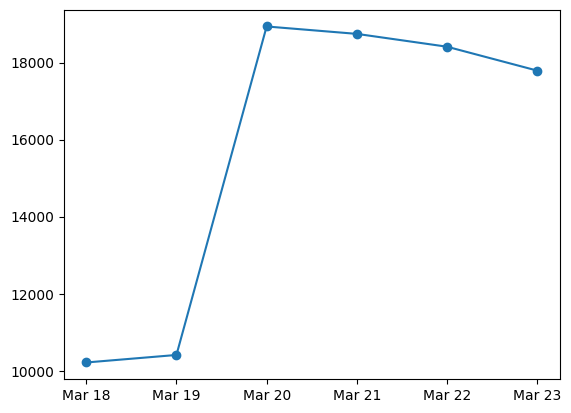

In [4]:
cmp = Financial_Extractor("TCS", 6)
cmp.plotter(attr='Tangible Assets')

#cmp.get_info()

In [5]:

#max years 20, add exception handling
company = Financial_Extractor("TCS", 6)
company.get_info()

retrieving data...
<Response [200]>
TCS balancesheet data is written successfully to Excel File.
<Response [200]>


PermissionError: [Errno 13] Permission denied: 'moneycontrol_TCS_profitloss.xlsx'

## Changelog:
### -further modularized and made the extractor into a class for ease of use and easier packaging
### -added BSE number/NSE option
### -added functionality to add number of years for financial statements
### avoids multiple webpage scraping based on number of years